# 06 - Parameter Recovery: Spatially Resolved Spectroscopy/Multi-distance Method

In this tutorial, we will discuss how to estimate the optical property parameters (namely $\mu_a$ and $\mu_s'$) using frequency-domain measurements. This is not to be confused with the tomographic reconstruction: here we aim to estimate the *background* optical properties as opposed to the *perturbations*. More specifically, we assume that the medium is large (i.e. can be approximated as semi-infinite), optically homogeneous, and that we know its refractive index (or can quantify it), and we wish to quantify the absorption and scattering properties.

Doing so using an FD system requires multiple source detector distances, and is therefore referred to as spatially resolved spectroscopy (SRS) or the multi-distance method. We will discuss two different flavors of how to do this, but the idea is essentially this: we assume the medium to be semi-infinite such that we know the analylitical form of the fluence, we then tweak the optical properties, such that calculated recording (using the analytical form) matches the actual recording. These current values would be our estimation of the optical properties of the medium

In [1]:
import sys
sys.path.insert(1, '../')
import nirfasterff as ff # ff is short for fast and furious
import numpy as np
import matplotlib.pyplot as plt

Let's now build a slab of 60mm x 60mm x 50mm that has one source and four detectors arranged along the same line, and assume it has $\mu_a=0.015$ mm$^{-1}$ and $\mu_s'=0.9$ mm$^{-1}$.

In fact, it is more common in reality to have one detector and multiple sources, because detectors can be more expensive. The math for the parameter recovery is however exactly the same, regardless.

In [2]:
# create a uniform volume, make sure it's in uint8
vol = np.ones((60,60,50), dtype=np.uint8)
# create a mesh from it
# meshing parameter
params = ff.utils.MeshingParams(general_cell_size=1.5, lloyd_smooth=0)
# optodes
sources = ff.base.optode(np.array([10,30,0]))
detectors = ff.base.optode(np.array([[20,30,0], 
                                    [30,30,0],
                                    [40,30,0],
                                    [50,30,0]]))
link = np.array([[1,1],
                [1,2],
                [1,3],
                [1,4]], dtype=np.int32) # if the third column is missing, automatically assumed to be all 1
# optical properties
prop = np.array([[1, 0.015, 0.9, 1.33]])
# now mesh
mesh = ff.base.stndmesh()
mesh.from_volume(vol, params, prop=prop, src=sources, det=detectors, link=link)

Running CGAL mesher
Meshing...

Running local optimization...

Converting to NIRFAST format


We usually leverage two pieces of information: log intensity vs source-detector distance, and phase vs source-detector distance. Let's generate some data and have a look.

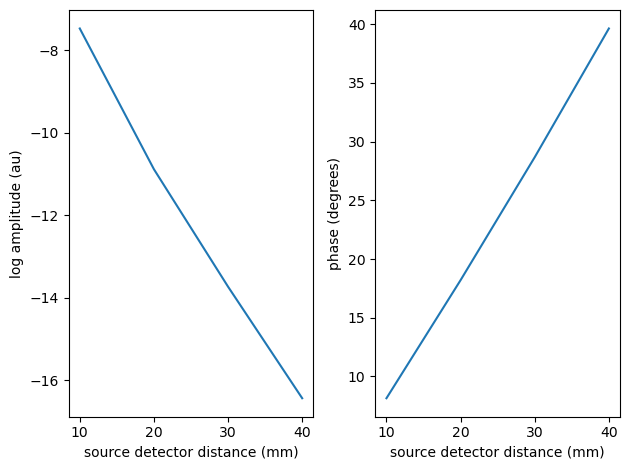

In [4]:
# let's generate some FD data, and have a look
data = mesh.femdata(1e8)[0] # 100MHz modulation
rho = np.array([10., 20, 30, 40])

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(rho, np.log(data.amplitude))
ax1.set_xlabel('source detector distance (mm)')
ax1.set_ylabel('log amplitude (au)')

ax2.plot(rho, data.phase)
ax2.set_xlabel('source detector distance (mm)')
ax2.set_ylabel('phase (degrees)')

plt.tight_layout()
plt.show()

We can, of course, calculate the exact same curves using the analytical solutions in semi-infinte media, using the functions provided in the NIRFASTer package. When the "correct" optical parameters are used, they should match exactly. Conveniently, we can use the `curve_fit` function provided by SciPy to look for these parameters to make the exact match.

We must be cautious, that since the FEM solution (or an experimental recording) and the analytical solution are often at completely different amplitudes, and consequently it is usually a good idea to shift the curves along the y-axis, such that the first point is zero. 

In [14]:
from scipy import optimize
def myfunc(rho, mua, musp):
    phi = ff.forward.semi_infinite_FD(mua, musp, 1.3, 1e8, rho)
    amplitude = np.log(np.abs(phi))
    phase = np.angle(phi, deg=True)
    return np.r_[amplitude-amplitude[0], phase-phase[0]] # make sure to normalize to the first position

# log intensity and phase concatenated to form the measurement vector
ydata = np.r_[np.log(data.amplitude/data.amplitude[0]), data.phase-data.phase[0]]
# we need to specify the bounds of the search
# let's say mua must be between 0.001~0.1 mm-1, and musp 0.1~10 mm-1
fitted = optimize.curve_fit(myfunc, rho, ydata, bounds=([1e-3, 1e-1], [1e-1, 1e1]))[0]
print(fitted)

[0.01414467 0.92764694]


That's quite good. We can also plot the analytical results using the fitted parameters together with the FEM results, and see how good our fit is.

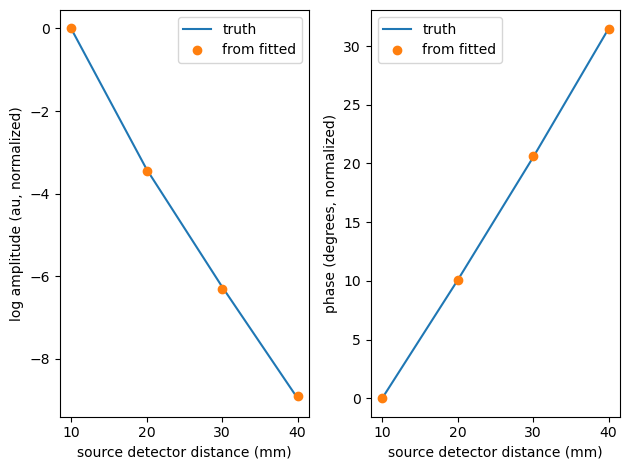

In [17]:
yhat = myfunc(rho, fitted[0], fitted[1])

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(rho, ydata[:4])
ax1.plot(rho, yhat[:4], 'o')
ax1.set_xlabel('source detector distance (mm)')
ax1.set_ylabel('log amplitude (au, normalized)')
ax1.legend(['truth', 'from fitted'])

ax2.plot(rho, ydata[4:])
ax2.plot(rho, yhat[4:],'o')
ax2.set_xlabel('source detector distance (mm)')
ax2.set_ylabel('phase (degrees, normalized)')
ax2.legend(['truth', 'from fitted'])

plt.tight_layout()
plt.show()

You may have already noticed that the log intensity decreases *almost* linearly with source-detector distance (let's call it $\rho$), and phase increases *almost perfectly* linearly with the source-detector distance. In fact, according to the analytical solution, in high scattering media ($1/\mu_s'\ll\rho$), the phase indeed has a linear relationship with $\rho$, and for the log intensity, the linearity is much better if we make a small change and plot $\log(\rho^2I)\sim\rho$ instead. Let's have a look

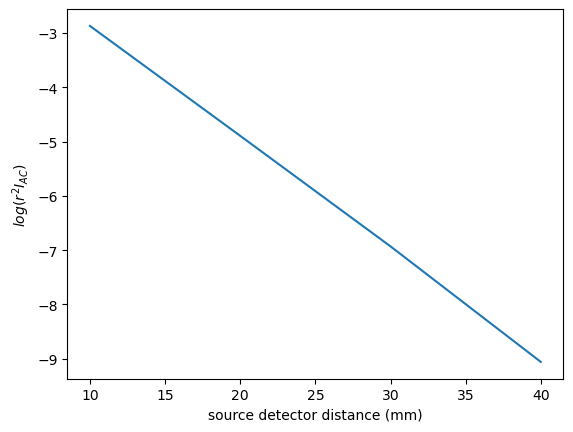

In [26]:
plt.plot(rho, np.log(rho**2 * data.amplitude))
plt.xlabel('source detector distance (mm)')
plt.ylabel('$log(r^2 I_{AC})$')
plt.show()

Now if we calculate the slopes of the two curves ($\log(\rho^2I)\sim\rho$ and $\phi\sim\rho$), we can use them to very conveniently give an estimation of the optical properties. And this motivates our flavor number two. Assuming that the semi-infinite analytical solution is used, the relationship is given by, if we denote the two slopes by $S_{ac}$ and $S_\phi$,
$$
\mu_a=\frac{\omega}{2\nu}\left(\frac{S_\phi}{S_{ac}} - \frac{S_{ac}}{S_\phi}\right)
$$
$$
\mu_s'=\frac{S_{ac}^2-S_\phi^2}{3\mu_a}-\mu_a
$$
This is given [here](https://doi.org/10.1088/0031-9155/44/6/308).

In the following cell, I'm fitting for the slope (in $y=a+bx$) using the least square method, but organized in the matrix form.

In [27]:
slope_ac = np.linalg.pinv(np.c_[np.ones(4), rho]) @ np.log(rho**2 * data.amplitude)
slope_ac = slope_ac[1]
slope_phi = np.linalg.pinv(np.c_[np.ones(4), rho]) @ (data.phase/180*np.pi) # imoprtant: use radian
slope_phi = slope_phi[1]

omega = 2*np.pi*1e8
v = 3e11 / 1.3
mua_fitted = 0.5*omega/v * (slope_phi/slope_ac - slope_ac/slope_phi)
musp_fitted = (slope_ac**2 - slope_phi**2)/3/mua_fitted - mua_fitted
print(mua_fitted)
print(musp_fitted)

0.015192133935395712
0.908958590940229


This is quite convenient, but do be noted that this method comes with many limitations due to the assumptions made. When the scattering coefficient is low, for example, the results might be off. It is, therefore, usually a good idea to plot the curves and check the linearity before blindly applying this method.

Now we have learned how to fit for optical properties using FD data. In the next tutorial, we will discuss how to fit for optical properties using time-resolved data.